In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

import networkx as nx

def unzip(l):
    return list(zip(*l))

# Make gaussian subsets to use for sampling

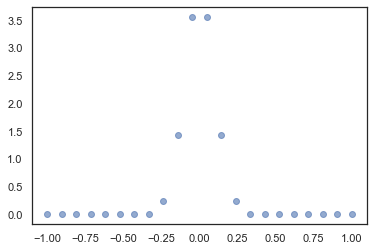

In [2]:
fig, ax = plt.subplots(1, 1)

rv = norm(loc=0, scale=0.1)
points = 11
x = np.linspace(-1, 1, points * 2)
ax.plot(x, list(rv.pdf(x)), "o", lw=5, alpha=0.6, label="norm pdf")

In [3]:
def normal_subsets(side_len, scale):
    rv = norm(loc=0, scale=scale)
    x = np.linspace(-1, 1, side_len * 2 + 1)
    p = rv.pdf(x)
    peak = side_len
    cols = list(range(side_len))
    subsets = []
    for col in cols:
        start = peak - col
        stop = start + side_len
        subset = np.array(p[start:stop])
        subset /= subset.sum()
        subsets.append(subset)
    for subset in subsets:
        assert np.isclose(subset.sum(), 1.0)
    return subsets

In [7]:
subsets = normal_subsets(10, 1)

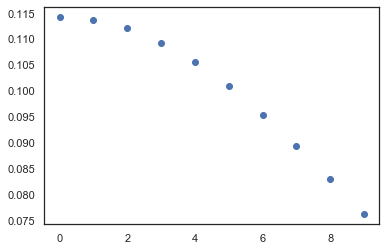

In [8]:
for subset in subsets[::10]:
    plt.plot(subset, "o")
    plt.show()

# Lattice layout to use with networkx

In [7]:
def make_layout(side_len):
    points = side_len ** 2
    x, y = np.meshgrid(np.arange(side_len), np.arange(side_len))  # make grid
    x, y = x.reshape(points), y.reshape(points)  # flatten to turn into pairs
    layout = {
        (points - 1 - idx): coords for idx, coords in enumerate(zip(reversed(x), y))
    }  # assign x,y to each node idx
    # points -1 and reverserd are used to match row/cols matrix format
    return layout

In [8]:
g = nx.Graph()
g.add_nodes_from(list(range(25)))

In [9]:
pos = make_layout(5)
pos

{24: (4, 0),
 23: (3, 0),
 22: (2, 0),
 21: (1, 0),
 20: (0, 0),
 19: (4, 1),
 18: (3, 1),
 17: (2, 1),
 16: (1, 1),
 15: (0, 1),
 14: (4, 2),
 13: (3, 2),
 12: (2, 2),
 11: (1, 2),
 10: (0, 2),
 9: (4, 3),
 8: (3, 3),
 7: (2, 3),
 6: (1, 3),
 5: (0, 3),
 4: (4, 4),
 3: (3, 4),
 2: (2, 4),
 1: (1, 4),
 0: (0, 4)}

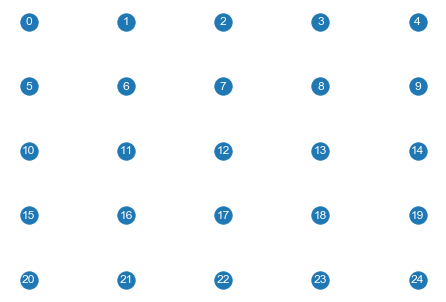

In [9]:
nx.draw(g, with_labels=True, pos=pos,font_color="white")

# Edge sampling strategies

In [12]:
# local uses the precomputed gaussian SUBSETS to connect to neighbours
def local_sample(
    node, samples, side_len
):  # boi this is a mindfuck, refer to the picture above
    col = node % side_len  # e.g. 11 % 5 -> col 1
    row = node // side_len  # e.g. 11 // 5 -> row 2
    points = np.arange(side_len)
    to_row = np.random.choice(points, p=subsets[row], size=samples)
    to_col = np.random.choice(points, p=subsets[col], size=samples)
    # reconstruct the node idx from rows and cols
    return [(node, to) for to in side_len * to_row + to_col if node != to]

# connect with everything at random
def random_sample(node, samples, num_points):
    points = np.hstack([np.arange(node), np.arange(node + 1, num_points)])
    edges = np.random.choice(points, size=samples)
    return [(node, to) for to in edges]

# mix of the previous two controlled by p -> fraction of local connections
def hybrid_sample(node, p, samples, side_len, num_points):
    assert 0 <= p and p <= 1
    _local = int(p * samples)
    _global = samples - _local
    # global
    global_points = np.hstack([np.arange(node), np.arange(node + 1, num_points)])
    global_edges = np.random.choice(global_points, size=_global)
    global_edges = [(node, to) for to in global_edges]
    # local
    col = node % side_len  # e.g. 11 % 5 -> col 1
    row = node // side_len  # e.g. 11 // 5 -> row 2
    local_points = np.arange(side_len)
    to_row = np.random.choice(local_points, p=subsets[row], size=_local)
    to_col = np.random.choice(local_points, p=subsets[col], size=_local)
    # reconstruct the node idx from rows and cols
    local_edges = [(node, to) for to in side_len * to_row + to_col if node != to]
    return local_edges + global_edges

In [13]:
side_len = 30
num_points = side_len ** 2
locality = 0.2
subsets = normal_subsets(side_len, locality)
nodes = list(range(num_points))

In [14]:
edges = local_sample(72, 10, side_len)

In [15]:
for _from, _to in edges:
    assert 0 <= _to and _to < num_points, _to
edges[:3]

[(72, 10), (72, 194), (72, 224)]

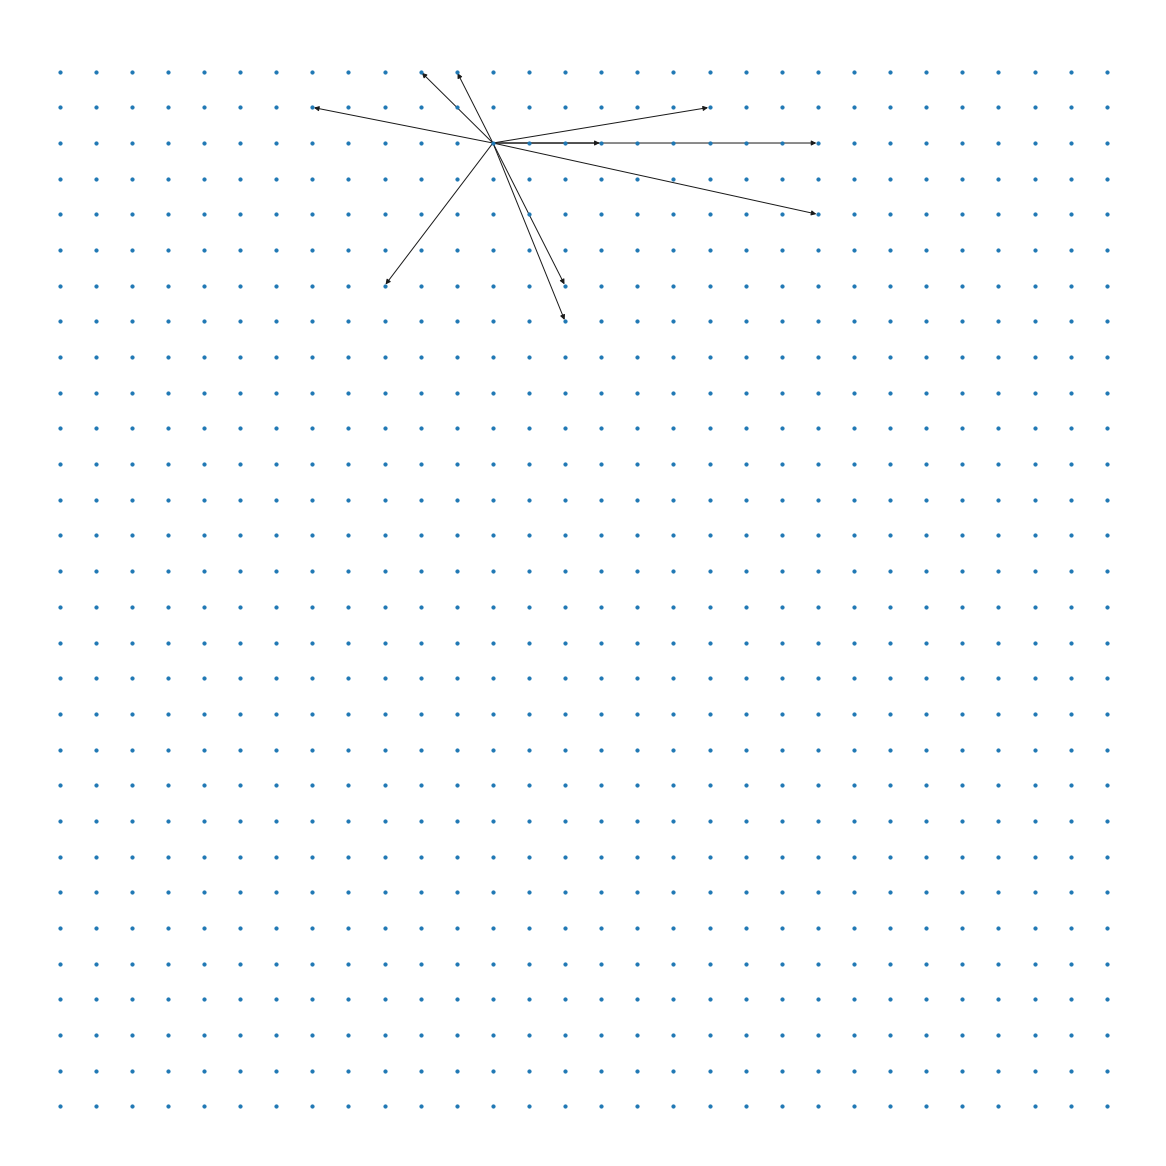

In [16]:
g = nx.DiGraph()
g.add_nodes_from(list(range(num_points)))
g.add_edges_from(edges)
pos = make_layout(side_len)
plt.figure(figsize=(16, 16))
nx.draw(g, with_labels=False, pos=pos, node_size=10)

In [17]:
side_len = 30
num_points = side_len ** 2
nodes = list(range(num_points))

In [18]:
edges = random_sample(72, 10, num_points)
for _from, _to in edges:
    assert 0 <= _to and _to < num_points, _to
edges[:3]

[(72, 875), (72, 829), (72, 477)]

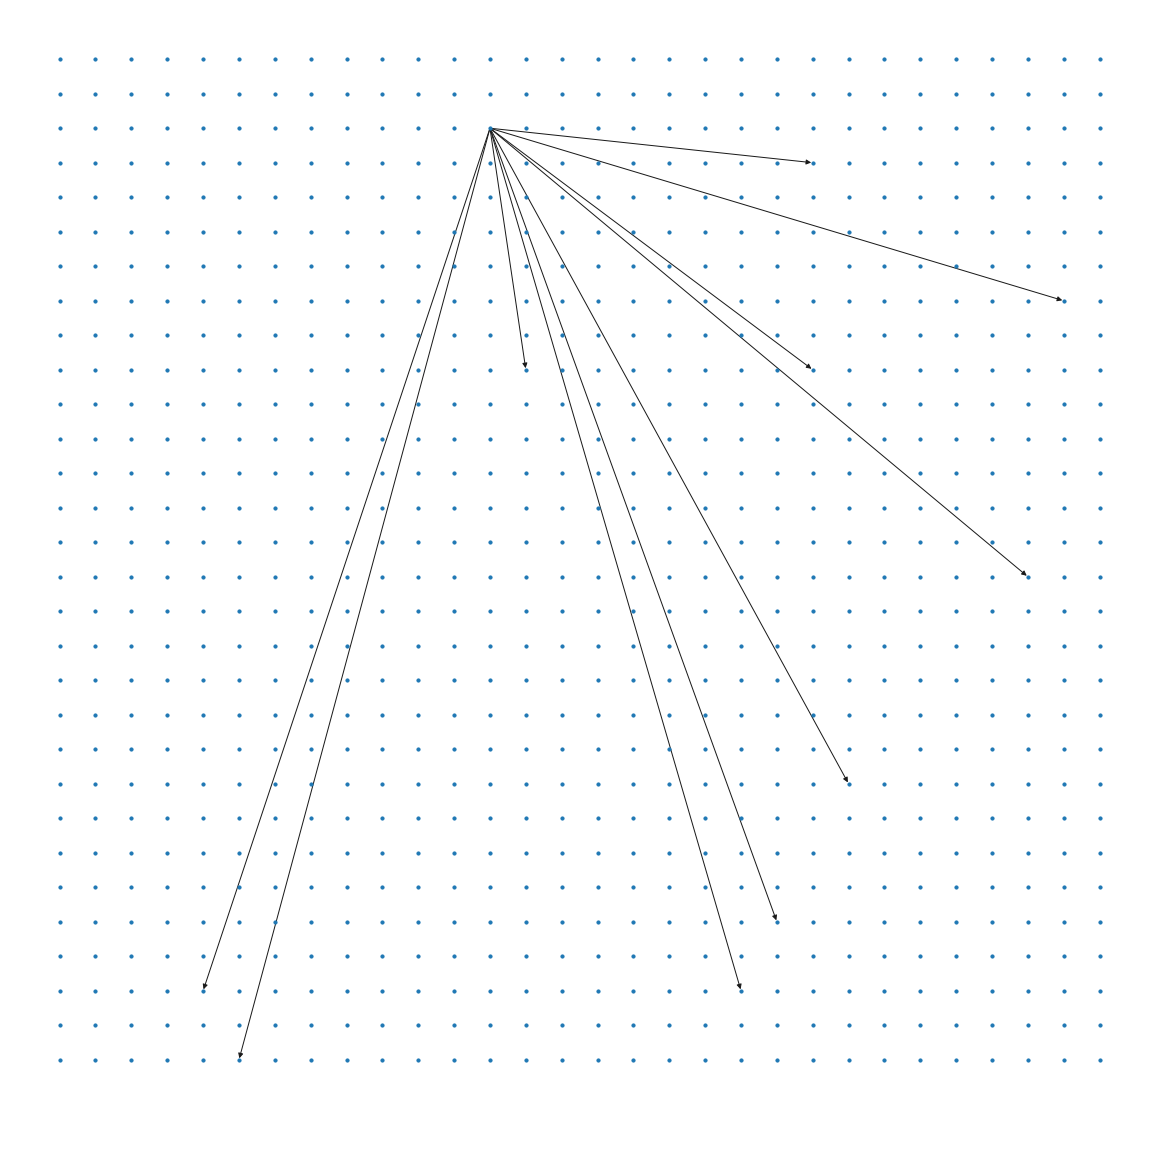

In [19]:
g = nx.DiGraph()
g.add_nodes_from(list(range(num_points)))
g.add_edges_from(edges)
pos = make_layout(side_len)
plt.figure(figsize=(16, 16))
nx.draw(g, with_labels=False, pos=pos, node_size=10)

# Visualize edge distributions

In [20]:
side_len = 50
num_points = side_len ** 2
locality = 0.2
subsets = normal_subsets(side_len, locality)
nodes = list(range(num_points))

Local gaussian from a center node, the marginal distributions (i.e. the per-axis slices are plotted on the side)

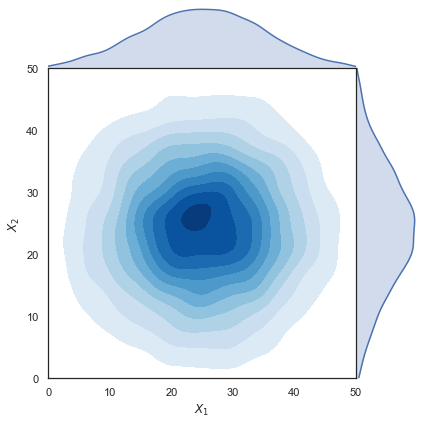

In [21]:
edges = local_sample(1225, 10000, side_len)
_, to = unzip(edges)
x1, x2 = unzip([(node % side_len, node // side_len) for node in to])
x1 = pd.Series(x1, name="$X_1$")
x2 = pd.Series(reversed(x2), name="$X_2$")

g = sns.JointGrid(x1,x2,space=0,xlim=(0, side_len), ylim=(0, side_len))
g = g.plot_joint(sns.kdeplot,cmap="Blues",shade=True, shade_lowest=False)
g = g.plot_marginals(sns.kdeplot,shade=True)

Local gaussian around a node close to an edge.

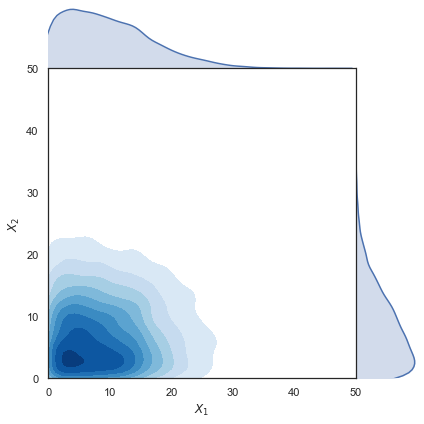

In [22]:
edges = local_sample(55, 10000, side_len)
_, to = unzip(edges)
x1, x2 = unzip([(node % side_len, node // side_len) for node in to])
x1 = pd.Series(x1, name="$X_1$")
x2 = pd.Series(reversed(x2), name="$X_2$")

# Show the joint distribution using kernel density estimation
g = sns.JointGrid(x1,x2,space=0,xlim=(0, side_len), ylim=(0, side_len))
g = g.plot_joint(sns.kdeplot,cmap="Blues",shade=True, shade_lowest=False)
g = g.plot_marginals(sns.kdeplot,shade=True)

Global uniform samples around a central node. 
Note how the marginals are almost flat (except on the edges, but that's because of the kernel used)

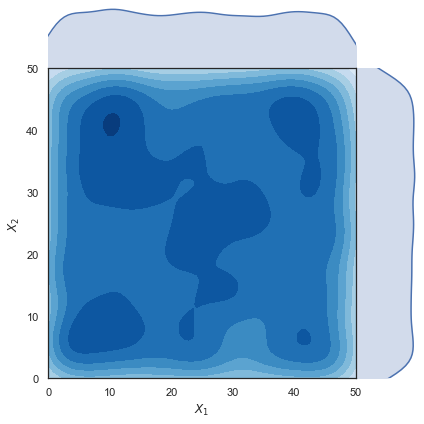

In [23]:
edges = random_sample(1225, 10000, num_points)
_, to = unzip(edges)
x1, x2 = unzip([(node % side_len, node // side_len) for node in to])
x1 = pd.Series(x1, name="$X_1$")
x2 = pd.Series(reversed(x2), name="$X_2$")

# Show the joint distribution using kernel density estimation
g = sns.JointGrid(x1,x2,space=0,xlim=(0, side_len), ylim=(0, side_len))
g = g.plot_joint(sns.kdeplot,cmap="Blues",shade=True, shade_lowest=False)
g = g.plot_marginals(sns.kdeplot,shade=True)

Hybrid samplig using a mixture of .5 gaussian, .5 uniform. Notice how the tails of the distribution are fatter because of the uniform samples. Seems biased in a cross shape because of the sampling mechanism. Bug or feature?

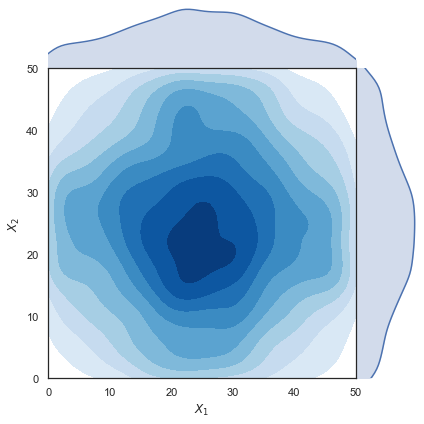

In [24]:
edges = hybrid_sample(
    node=1225, p=0.5, samples=10000, side_len=side_len, num_points=num_points
)
_, to = unzip(edges)
x1, x2 = unzip([(node % side_len, node // side_len) for node in to])
x1 = pd.Series(x1, name="$X_1$")
x2 = pd.Series(reversed(x2), name="$X_2$")

# Show the joint distribution using kernel density estimation
g = sns.JointGrid(x1,x2,space=0,xlim=(0, side_len), ylim=(0, side_len))
g = g.plot_joint(sns.kdeplot,cmap="Blues",shade=True, shade_lowest=False)
g = g.plot_marginals(sns.kdeplot,shade=True)

---------------

# Csenge's old stuff

## Building actual networks

Initial network

In [25]:
side_len = 30
num_points = side_len ** 2
locality = 0.2
subsets = normal_subsets(side_len, locality)
nodes = list(range(num_points))
init_M = 10 #number of edges each node has at the beginning
init_N = 60 #number of nodes that have edges in the beginning
new_M = 5 #number of edges to add to a chosen node at each "try"
new_N = 5 #number of nodes to add new edges to at each "try"
edges = []
num_fire = 10 #number of nodes that fire in response to input
th = 100 #number of signals that initiate firing of node
node_fired_once = [] #nodes that fired at least once, will be needed for fitness

In [26]:
nodes_to_add_to = random.sample(nodes, k=init_N) #choose nodes to add edges to

In [27]:
for node in nodes_to_add_to:
    edges.extend(local_sample(node, init_M, side_len)) #could also use random_sample or hybrid_sample

In [28]:
activity_state = np.zeros(num_points)
activity_state_draw = [x + 10 for x in activity_state]
len(activity_state_draw)

900

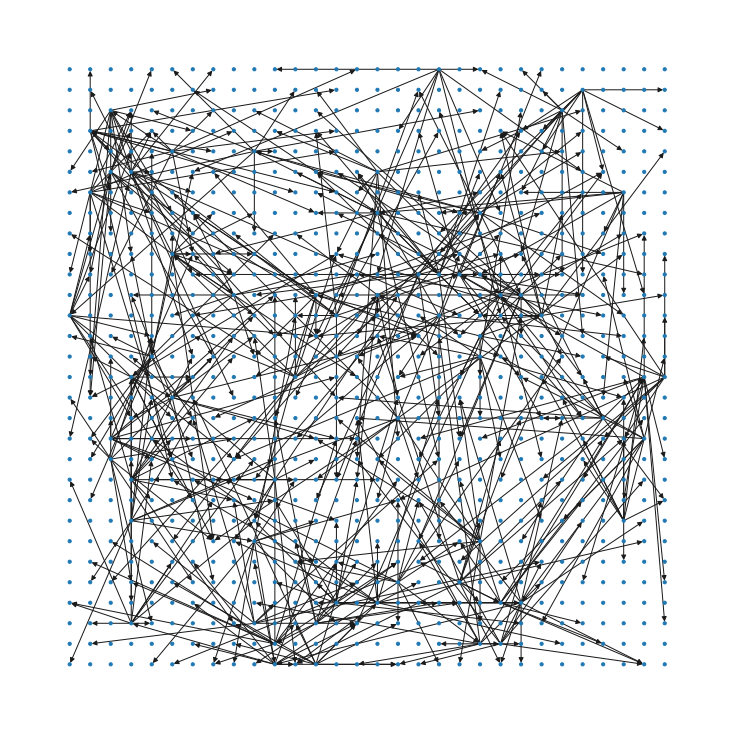

In [29]:
g = nx.DiGraph()
g.add_nodes_from(list(range(num_points)))
g.add_edges_from(edges)
pos = make_layout(side_len)
plt.figure(figsize=(10, 10))
nx.draw(g, with_labels=False, pos=pos, node_size=activity_state_draw)

Test fintess of initial network
note: if node number is at the second place in edge list -> incoming edge, if node number is first place -> outgoing edge

In [30]:
init_fire = random.sample(nodes, k=num_fire)
init_fire

[267, 63, 878, 521, 872, 825, 225, 836, 755, 172]

In [31]:
activity_state[init_fire] = th

In [32]:
#sending out signals if activity_state > th
def let_them_go(activity_state):
    firing_nodes = np.where(activity_state >= th)
    firing_nodes_f = [item for t in firing_nodes for item in t] 
    nodes_that_receive = []
    for x in firing_nodes_f:
        #edges_sending = [item for item in edges if x in item]
        #nodes_to_receive1 = [beg for (beg,end) in edges if end == x]
        node_fired_once.append(x)
        nodes_that_receive.extend([end for (beg,end) in edges if beg == x])  # because we are looking for nodes where edge leads
        print(nodes_that_receive)
    activity_state[nodes_that_receive] += 20
    activity_state[firing_nodes] = 0
    return activity_state

In [33]:
n_above_th = np.where(activity_state >= th)
n_above_th_f = [item for t in n_above_th for item in t] 
while len(n_above_th_f) > 0:
    new_activity_state = let_them_go(activity_state)
    n_above_th = np.where(new_activity_state >= th)
    n_above_th_f = [item for t in n_above_th for item in t]
    print("updated network states")

[]
[]
[588, 200, 380, 222, 318, 36, 277, 328, 161, 402]
[588, 200, 380, 222, 318, 36, 277, 328, 161, 402]
[588, 200, 380, 222, 318, 36, 277, 328, 161, 402]
[588, 200, 380, 222, 318, 36, 277, 328, 161, 402]
[588, 200, 380, 222, 318, 36, 277, 328, 161, 402]
[588, 200, 380, 222, 318, 36, 277, 328, 161, 402]
[588, 200, 380, 222, 318, 36, 277, 328, 161, 402]
[588, 200, 380, 222, 318, 36, 277, 328, 161, 402]
updated network states


In [34]:
init_fire

[267, 63, 878, 521, 872, 825, 225, 836, 755, 172]

In [35]:
color_map = []
for node in nodes:
    if (node in init_fire):
        color_map.append('red')
    else:
        color_map.append('blue')

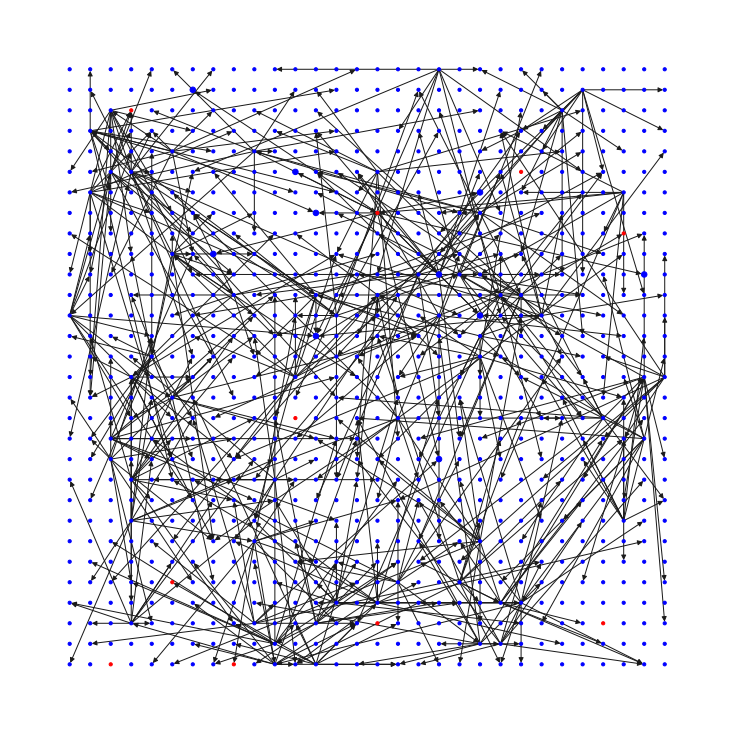

In [36]:
new_activity_state_draw = [x + 10 for x in new_activity_state]
plt.figure(figsize=(10, 10))
nx.draw(g, node_color = color_map, with_labels=False, pos=pos, node_size=new_activity_state_draw)

In [37]:
node_fired_once

[63, 172, 225, 267, 521, 755, 825, 836, 872, 878]

In [ ]:
#num_edges = sum(map(len, network.adjlist.values())) ,checking total number of edges